<a href="https://colab.research.google.com/github/Square-Pot/colab-tools/blob/main/SVG_Label_Maker_Horizontal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVG-Label Maker

Генератор горизонтальных бирок в SVG-формате на основе данных из google-таблиц.  
Фрагмент таблицы c исходными данными (полный перечень столбцов - см класс **Plant**):

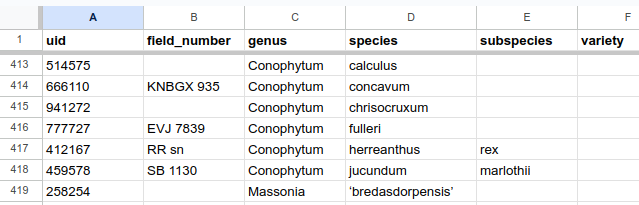

In [1]:
# Install dependencies
!pip install svgwrite
!pip install ppf-datamatrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.0 MB/s eta 0:00:00


In [53]:
#!/usr/bin/env python
import os
from pathlib import Path
from dataclasses import dataclass
import datetime
import svgwrite
from svgwrite import cm, mm
from ppf.datamatrix import DataMatrix


@dataclass
class Plant:
    uid: str = None
    field_number: str = None
    genus: str = None
    species: str = None
    subspecies: str = None
    variety: str = None
    cultivated_variety: str = None
    synonym: str = None
    form: str = None
    affinity: str = None
    ex: str = None
    locality: str = None
    information: str = None
    source: str = None
    seeding_date: datetime = None
    purchase_date: datetime = None
    price: float = None


    @property
    def from_seed(self):
        return True if self.seeding_date else False

    @property
    def has_field_num(self):
        return True if self.field_number else False


class Label:
    # Main dimentions / Габаритные размеры бирки
    W = 76                          # Label width, should be lower than pot width / Ширина бирки, должна быть чуть меньше ширины горшка
    H = 10                          # Label hight, visible part of it / Высота бирки, видимая часть над горшком
    D = H * 1.5                     # Underground part of lable hight
    CHAMFER = 3

    # Field number zone / Место для полевого номера
    FIELD_H = H / 2                 # Field number frame size
    FIELD_W = W / 6
    FIELD_FONT_SIZE = 16            # px, размер шрифтов здесь и далее не масштабируется, подбирается вручную

    # Main text settings / Основная надпись (над уровнем субстрата)
    MAIN_TEXT_PADDING_START = 2
    MAIN_TEXT_PADDING_BOTTOM = 1
    MAIN_FONT_SIZE = 10
    CHAR_SIZE = 1.57

    # Data Matrix settings / Полодение и размеры матрицы
    DM_H = H * 0.9                  # Data matrix zone hight
    DM_W = H * 0.9                  # Data matrix zone width
    DM_X = W - DM_H                 # Data matrix location
    DM_Y = 0
    DM_FONT_SIZE = 8                # px

    # Additional info settings / Настройки дополнительной текстовой части (под землей)
    ADD_FONT_SIZE = 9               # px


    def __init__(self, k=1):
        self.W = Label.W * k
        self.H = Label.H * k
        self.D = Label.D * k
        self.has_field_num = None
        self.FIELD_H = Label.FIELD_H * k
        self.FIELD_W = Label.FIELD_W * k
        self.MAIN_TEXT_PS = Label.MAIN_TEXT_PADDING_START * k
        self.MAIN_TEXT_PB = Label.MAIN_TEXT_PADDING_BOTTOM * k
        self.DM_H = Label.DM_H * k
        self.DM_W = Label.DM_W * k
        self.DM_X = Label.DM_X * k
        self.DM_Y = Label.DM_Y * k
        self.drawing = None
        self.__make_drawing()
        self.__make_borders()

    def get_main_txt_x(self):
        if self.has_field_num:
            return self.FIELD_W + self.MAIN_TEXT_PS
        else:
            return Label.MAIN_TEXT_PADDING_START

    def get_main_txt_width(self):
        return self.DM_X - self.get_main_txt_x() - 3

    def get_chars_per_line(self):
        return self.get_main_txt_width() / Label.CHAR_SIZE

    def get_add_txt_y(self):
        return self.H * 3.78 + Label.ADD_FONT_SIZE

    def __make_drawing(self):
        w = self.W * mm
        h_d = (self.H + self.D) * mm
        self.drawing = svgwrite.Drawing(size=(w, h_d)) # , style="border:solid 1px")

    def __make_borders(self):
        w = self.W * mm
        h = self.H * mm
        d = self.D * mm
        h_d = (self.H + self.D) * mm
        left_line = self.drawing.add(self.drawing.line((0, 0), (0, h), stroke = 'black'))
        right_line = self.drawing.add(self.drawing.line((w, 0), (w, h), stroke = 'black'))
        top_line = self.drawing.add(self.drawing.line((0, 0), (w, 0), stroke = 'black'))
        soil_level_line = self.drawing.add(self.drawing.line((0, h), (w, h), stroke = 'black'))
        soil_level_line.dasharray([5, 5])
        left_shift_x = (self.D / Label.CHAMFER)  * mm
        right_shift_x = (self.W - self.D / Label.CHAMFER) * mm
        left_cutting_line = self.drawing.add(self.drawing.line((0, h), (left_shift_x, h_d), stroke = 'black'))
        right_cutting_line = self.drawing.add(self.drawing.line((w, h), (right_shift_x, h_d), stroke = 'black'))
        bottom_line = self.drawing.add(self.drawing.line((left_shift_x, h_d), (right_shift_x, h_d), stroke = 'black'))

    def save(self):
        self.drawing.save()


class LabelFactory:
    def __init__(self):
        self.plants: list[Plant] = None
        self.dwg = svgwrite.Drawing()

    def set_plants(self, plants: list[Plant]):
        self.plants = plants

    def make_labels(self):
        labels = []
        for plant in self.plants:
            label = self.__make_label(plant)
            labels.append(label)
        return labels

    def __make_label(self, plant):
        label = Label()
        label = self.__add_field_num(plant, label)
        label = self.__add_main_txt(plant, label)
        label = self.__add_datamatrix(plant, label)
        label = self.__additionl_info(plant, label)
        # label.save()
        return label

    def __add_field_num(self, plant, label):
        if not plant.field_number:
            return label
        label.has_field_num = True
        field_num_x = label.FIELD_W * mm
        field_num_y = label.FIELD_H * mm
        field_num_v_line = self.dwg.line((field_num_x, 0), (field_num_x, field_num_y), stroke = 'black')
        field_num_h_line = self.dwg.line((0, field_num_y), (field_num_x, field_num_y), stroke = 'black')
        field_num_txt = self.dwg.text(
            plant.field_number,
            x=[(label.FIELD_W/2)*mm],
            y=[(label.FIELD_H/2 + 0.5)*mm],
            style=f"font: bold { label.FIELD_FONT_SIZE }px sans-serif; dominant-baseline: middle; text-anchor: middle;",
            textLength = (label.FIELD_W - 1) * mm,
            lengthAdjust = 'spacingAndGlyphs'
        )
        label.drawing.add(field_num_v_line)
        label.drawing.add(field_num_h_line)
        label.drawing.add(field_num_txt)
        label.field_num_x = field_num_x
        label.field_num_y = field_num_y
        return label

    def __add_main_txt(self, plant, label):
        main_txt_x = label.get_main_txt_x()
        first_txt_line = self.dwg.text(
            '',
            x=[main_txt_x * mm],
            y=[(label.H / 2 - label.MAIN_TEXT_PB) * mm]
            )
        second_txt_line = self.dwg.text('', x=[main_txt_x * mm], y=[(label.H - label.MAIN_TEXT_PB * 2 ) * mm])
        first_txt_line.add(self.dwg.tspan(f"{ plant.genus[:1] }. ", style="font-style: italic"))
        data_cnt = 0
        work_line = first_txt_line
        if plant.species:
            data_cnt += 1
            work_line.add(self.dwg.tspan(f"{ plant.species } ", style="font-style: italic"))
        if plant.subspecies:
            data_cnt += 1
            work_line.add(self.dwg.tspan(" ssp. ", style="font-style: normal"))
            work_line.add(self.dwg.tspan(f"{ plant.subspecies } ", style="font-style: italic"))
        if plant.variety:
            data_cnt += 1
            if data_cnt > 2:
                work_line = second_txt_line
            work_line.add(self.dwg.tspan(" v. ", style="font-style: normal"))
            work_line.add( self.dwg.tspan(f"{ plant.variety } ", style="font-style: italic"))
        if plant.cultivated_variety:
            data_cnt += 1
            if data_cnt > 2:
                work_line = second_txt_line
            work_line.add(self.dwg.tspan(" cv. ", style="font-style: normal"))
            work_line.add(self.dwg.tspan(f"`{ plant.cultivated_variety }`", style="font-style: italic"))

        if self.count_chars(first_txt_line) > label.get_chars_per_line():
            first_txt_line.update({
                'textLength': label.get_main_txt_width() * mm,
                'lengthAdjust': 'spacingAndGlyphs'
            })

        if self.count_chars(second_txt_line) > label.get_chars_per_line():
            second_txt_line.update({
                'textLength': label.get_main_txt_width() * mm,
                'lengthAdjust': 'spacingAndGlyphs'
            })

        group = self.dwg.g()
        group.add(first_txt_line)
        if data_cnt > 2:
            group.add(second_txt_line)
        label.drawing.add(group)
        return label

    def __add_datamatrix(self, plant, label):
        Path('matrix').mkdir(parents=True, exist_ok=True)
        matrix_svg = DataMatrix(plant.uid)
        matrix_file_path = os.path.join('matrix', f'{plant.uid}.svg')
        with open(matrix_file_path, "w") as f:
            f.write(matrix_svg.svg())
        label.drawing.add(self.dwg.image(href=(matrix_file_path), insert=((label.DM_X - 0.5) * mm, (label.DM_Y + 0.5) * mm), size=(label.DM_W * mm, label.DM_H * mm)))
        x = (label.DM_X - 2.5) * mm
        y = (label.DM_Y + 2) * mm
        text_uid = self.dwg.text(
                plant.uid,
                x = [x],
                y = [y],
                style = f"font-size: {Label.DM_FONT_SIZE};",
                transform = f"rotate(90,{(label.DM_X - 2.5)*3.78},{(label.DM_Y + 2)*3.78})",
        )

        label.drawing.add(text_uid)
        return label


    def __additionl_info(self, plant, label):
        additional_data_attrs = [
            'synonym',
            'form',
            'affinity',
            'ex',
            'locality',
            'source',
            'information',
            'seeding_date',
            'purchase_date',
        ]
        x = label.D / Label.CHAMFER + 2
        y = label.get_add_txt_y() + 2
        line_height = Label.ADD_FONT_SIZE
        for attr in additional_data_attrs:
            val = getattr(plant, attr)
            if val:
                add_line = self.dwg.text('', x=[x * mm], y=[y])
                add_line.add(self.dwg.tspan(f'{ attr.capitalize() }: ', style=f"font-weight: bold; font-size: { Label.ADD_FONT_SIZE }; font-family: Arial"))
                add_line.add(self.dwg.tspan(f'{ val }', style=f"font-weight: normal; font-size: { Label.ADD_FONT_SIZE }; font-family: Arial"))
                label.drawing.add(add_line)
                y += line_height
        return label


    @staticmethod
    def count_chars(txt: svgwrite.text.Text) -> int:
        cnt = 0
        for tspan in txt.elements:
            cnt += len(tspan.text)
        return cnt


def make_svg_pages(labels: list[Label]) -> list[str]:
    """
    Makes svg-pages with labels and save it as svg-files.
    Returns lits of filenames
    """

    # Page size in mm (A4 page is 210x297 mm)
    PAGE_W = 210
    PAGE_H = 297

    # Page margin
    MARGIN_X = 10
    MARGIN_Y = 10

    # Line and column space
    SPACE_V = 3
    SPACE_H = 5

    page_cnt = 1
    page_filename = f'page_{ page_cnt }.svg'
    pages = [page_filename,]
    page = svgwrite.Drawing(page_filename, size=(PAGE_W * mm, PAGE_H * mm), style="border:solid 1px; background-color: white; ")
    x = MARGIN_X
    y = MARGIN_Y
    for i, label in enumerate(labels):
        width = label.W
        heigh = label.H + label.D
        if (x + width) > PAGE_W:
            page.save()
            page_cnt += 1
            page_filename = f'page_{ page_cnt }.svg'
            pages.append(page_filename)
            page = svgwrite.Drawing(page_filename, size=(PAGE_W * mm, PAGE_H * mm), style="border:solid 1px")
            x = MARGIN_X
            y = MARGIN_Y
        container = svgwrite.Drawing(size=(width * mm, heigh * mm), style="border:solid 1px", insert=(x * mm, y * mm))
        container.add(label.drawing)
        page.add(container)
        y = y + heigh + SPACE_V
        if (y + heigh) > PAGE_H:
            y = MARGIN_Y
            x = x + width + SPACE_H
    page.save()
    return pages


In [37]:
# Google Drive mounting
from google.colab import drive
drive.mount('/content/drive/')

# Google authorize
from google.colab import auth
auth.authenticate_user()

# Open spreadsheet
import gspread
from google.auth import default
SPREADSHEET_NAME = 'succulents_data'
creds, _ = default()
gc = gspread.authorize(creds)
sh = gc.open(SPREADSHEET_NAME).sheet1

# get_all_values gives a list of rows.
rows = sh.get_all_values()

# make pandas dataframe
import pandas as pd
df = pd.DataFrame.from_records(rows)

# set header
header = df.iloc[0]
df = df[1:]
df.columns = header

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [54]:
# get `October Marathon 2023` slice
marathon_df = df.iloc[429:487]

def make_plant(df_row) -> Plant:
    """
    Create empty Plant object and fill it with data
    Returns Plant object
    """
    plant = Plant()
    for key in df_row.keys():
        value = df_row[key]
        if value:
            setattr(plant, key, df_row[key])
    return plant


plants = []
for index, row in marathon_df.iterrows():
    plants.append(make_plant(row))

lf = LabelFactory()
lf.set_plants(plants)
labels = lf.make_labels()
svg_pages_files = make_svg_pages(labels)
